# Problema de Negocio (Enunciado de Kaggle)

### Descripción

Lucas ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Lucas a mejorar ese modelo?

### Evaluación

Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión.

RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{d_i - f_i}{\sigma_i}\right)^2}$$

### Referencia

[Iván Cordero. (2024). Plan de negocio – DataTops®. Kaggle.](https://kaggle.com/competitions/datatops)


# Estrategia 3

Voy a preparar los datos de forma que pueda ser aceptado por todos los modelos. Es decir, modificar el target para que tenga una distribución gaussina (normal), codificar las variables categóricas, y estandarizar los resultados.

# 0. Librerías

In [85]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor

from utils import datascience as ds
from utils import machinelearningtools as ml
from utils import vizdatatools as viz
from utils.functions import kaggle_checker

# Establecer un estilo moderno con Seaborn
sns.set_theme(style="darkgrid", palette='bright')


# 1. Entendiendo el problema de negocio

El principal objetivo del proyecto es crear un modelo de Machine Learning que permita a Lucas:

- Establecer precios precisos: Determinar el precio de venta ideal para cada portátil, considerando sus características técnicas.
- El rendimiento del modelo será evaluado utilizando el Error Cuadrático Medio (RMSE).
- Contamos con dos sets de trabajo:
    - `train.csv`: set de *train* sobre el que evaluaré las métricas y con el que entrenaré el modelo.
    - `test.csv`: set de *test* con el que predecir los precios de los portátiles, cuyo resultado (*submission*) se cargará a Kaggle.


# 2. Obtener datos y un primer vistazo.

In [86]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df_train = pd.read_csv(r'data/train.csv', index_col=0)
# df_train.index.name = None

df_train.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
laptop_ID,,,,,,,,,,,,
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [88]:
for col in df_train.columns:
    print(col)
    display(df_train[col].unique())

Company


array(['HP', 'Dell', 'Apple', 'Lenovo', 'MSI', 'Toshiba', 'Acer', 'Chuwi',
       'Asus', 'Huawei', 'Razer', 'Mediacom', 'Google', 'Samsung',
       'Xiaomi', 'Microsoft', 'Vero', 'LG', 'Fujitsu'], dtype=object)

Product


array(['250 G6', 'Inspiron 7559', 'ProBook 450', 'Macbook Air',
       'Inspiron 3567', 'ProBook 650', 'Envy 13-AD007nv',
       'IdeaPad 320-15IKB', 'GL72M 7REX', 'Thinkpad T570', 'MacBook Pro',
       'Ideapad 320-15IKBR', 'IdeaPad 320-15IAP', 'Portege Z30-C-16P',
       'Latitude 5590', 'IdeaPad 110-15IBR', 'GP72MVR 7RFX',
       'ThinkPad X1', 'GL62 6QF', 'Portege X30-D-10X', 'Chromebook 11',
       'Inspiron 5567', 'IdeaPad 510s-14IKB', 'LapBook 15.6"',
       'GE62 Apache', 'ZBook 17', 'Inspiron 7567', 'VivoBook Pro',
       'Pro P2540UA-XO0198T', 'Thinkpad 13', 'MateBook X', 'Vostro 5568',
       '250 G5', 'EliteBook 840', 'Inspiron 7570', 'IdeaPad Y700-15ISK',
       'ThinkPad P51', 'IdeaPad 320-15IKBN', 'Portege Z30-C-1CV',
       'XPS 13', 'IdeaPad 510-15IKB',
       '15-bs002nv (i3-6006U/4GB/128GB/FHD/W10)', 'Blade Pro',
       'Rog Strix', 'ProBook 440', '15-AC110nv (i7-6500U/6GB/1TB/Radeon',
       'Probook 440', 'FX753VD-GC071T (i7-7700HQ/8GB/1TB/GeForce',
       'GS73VR 

TypeName


array(['Notebook', 'Gaming', 'Ultrabook', 'Workstation', 'Netbook',
       '2 in 1 Convertible'], dtype=object)

Inches


array([15.6, 13.3, 14. , 17.3, 11.6, 13. , 12. , 10.1, 12.5, 12.3, 15. ,
       14.1, 13.5, 11.3, 13.9, 15.4, 18.4])

ScreenResolution


array(['Full HD 1920x1080', '1440x900', '1366x768',
       'IPS Panel Full HD 1920x1080', 'IPS Panel 4K Ultra HD 3840x2160',
       'IPS Panel Retina Display 2560x1600', 'Touchscreen 1366x768',
       'IPS Panel Quad HD+ 2560x1440', 'IPS Panel 1366x768',
       'Full HD / Touchscreen 1920x1080', 'IPS Panel Full HD 2160x1440',
       'Quad HD+ 3200x1800', '4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'IPS Panel Touchscreen 1920x1200',
       'IPS Panel Touchscreen 2560x1440', 'Touchscreen 2400x1600',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2560x1440', 'Quad HD+ / Touchscreen 3200x1800',
       '4K Ultra HD 3840x2160',
       'IPS Panel Quad HD+ / Touchscreen 3200x1800',
       'Touchscreen 2256x1504', '1600x900',
       'IPS Panel Touchscreen 1366x768',
       'Touchscreen / Quad HD+ 3200x1800', 'IPS Panel 2560x1440',
       'IPS Panel Quad HD+ 3200x

Cpu


array(['Intel Core i3 6006U 2GHz', 'Intel Core i7 6700HQ 2.6GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i3 6006U 2.0GHz', 'Intel Core i5 7300U 2.6GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i3 7100U 2.4GHz',
       'Intel Core i7 7700HQ 2.8GHz', 'Intel Core i7 7600U 2.8GHz',
       'Intel Core i5 2.9GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Core i7 6500U 2.5GHz', 'Intel Core i7 8650U 1.9GHz',
       'Intel Celeron Quad Core N3710 1.6GHz',
       'Intel Celeron Dual Core N3060 1.6GHz',
       'Intel Atom x5-Z8300 1.44GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'Intel Pentium Quad Core N3710 1.6GHz',
       'Intel Core i5 6200U 2.3GHz', 'Intel Core i5 8250U 1.6GHz',
       'AMD Ryzen 1700 3GHz', 'Intel Core i7 7820HK 2.9GHz',
       'Intel Core i5 1.3GHz', 'Intel Pentium Quad Core N3700 1.6GHz',
       'AMD A9-Series A9-9420 3GHz', 'Intel Core i7 7560U 2.4GHz',
       'Intel Core i

Ram


array(['8GB', '16GB', '4GB', '12GB', '32GB', '6GB', '2GB', '64GB', '24GB'],
      dtype=object)

Memory


array(['256GB SSD', '1TB HDD', '128GB Flash Storage',
       '128GB SSD +  1TB HDD', '512GB SSD', '500GB HDD',
       '256GB SSD +  256GB SSD', '128GB SSD', '32GB Flash Storage',
       '64GB Flash Storage', '1.0TB Hybrid', '2TB HDD',
       '256GB Flash Storage', '256GB SSD +  1TB HDD', '180GB SSD',
       '16GB Flash Storage', '1TB SSD', '256GB SSD +  2TB HDD',
       '32GB SSD', '1TB SSD +  1TB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  1TB HDD', '512GB SSD +  512GB SSD',
       '512GB SSD +  256GB SSD', '16GB SSD',
       '64GB Flash Storage +  1TB HDD', '64GB SSD', '128GB HDD',
       '240GB SSD', '512GB SSD +  2TB HDD', '508GB Hybrid', '8GB SSD',
       '256GB SSD +  500GB HDD', '1.0TB HDD', '512GB Flash Storage',
       '1TB HDD +  1TB HDD', '32GB HDD'], dtype=object)

Gpu


array(['Intel HD Graphics 520', 'Nvidia GeForce GTX 960<U+039C>',
       'Nvidia GeForce 930MX', 'Intel HD Graphics 6000',
       'AMD Radeon R5 M430', 'Intel HD Graphics 620',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050 Ti',
       'Intel Iris Graphics 550', 'Intel HD Graphics 505',
       'Intel UHD Graphics 620', 'Intel HD Graphics 405',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce GTX 960M',
       'Intel HD Graphics 400', 'AMD Radeon R7 M445',
       'AMD Radeon R7 M460', 'Intel HD Graphics', 'AMD FirePro W6150M',
       'Nvidia GeForce GTX 1050', 'Nvidia Quadro M1200',
       'AMD Radeon RX 580', 'Nvidia GeForce GTX 1080',
       'AMD Radeon R5 M330', 'Nvidia GeForce GTX 1070',
       'Intel HD Graphics 615', 'AMD Radeon 530', 'AMD Radeon 520',
       'Nvidia Quadro M620', 'Intel Iris Plus Graphics 640',
       'Nvidia Quadro M500M', 'Intel HD Graphics 510',
       'Intel Iris Plus Graphics 650', 'Nvidia GeForce 920MX ',
       'Intel HD Graphics 500', 'AMD Radeo

OpSys


array(['Windows 10', 'macOS', 'Linux', 'No OS', 'Chrome OS', 'Windows 7',
       'Android', 'Windows 10 S', 'Mac OS X'], dtype=object)

Weight


array(['1.86kg', '2.59kg', '2.04kg', '1.34kg', '2.25kg', '2.31kg',
       '1.32kg', '2.2kg', '2.7kg', '2.3kg', '1.37kg', '1.2kg', '1.88kg',
       '1.17kg', '1.05kg', '1.35kg', '1.5kg', '1.89kg', '2.4kg', '3.0kg',
       '2.65kg', '1.99kg', '2.37kg', '1.4kg', '2.36kg', '2.18kg',
       '1.96kg', '1.54kg', '3.14kg', '1.9kg', '1.13kg', '2.6kg', '2.67kg',
       '1.3kg', '1.91kg', '1.95kg', '3.25kg', '1.64kg', '1.44kg',
       '1.26kg', '3.49kg', '2.19kg', '1.63kg', '3kg', '2.43kg', '0.92kg',
       '2.1kg', '2.5kg', '1.48kg', '1.43kg', '2.06kg', '1.23kg', '1.8kg',
       '1.45kg', '1.93kg', '2.32kg', '0.69kg', '1.27kg', '1.25kg',
       '3.35kg', '2.56kg', '2.45kg', '1.47kg', '4.5kg', '2.0kg', '1.36kg',
       '1.1kg', '1.71kg', '1.21kg', '1.7kg', '1.94kg', '1.14kg', '1.6kg',
       '1.29kg', '2.05kg', '1.49kg', '4.36kg', '2.62kg', '2.21kg',
       '1.84kg', '2.17kg', '1.16kg', '2kg', '2.29kg', '2.9kg', '2.8kg',
       '1.65kg', '3.78kg', '2.73kg', '1.252kg', '0.98kg', '2.20kg',
       '

Price_in_euros


array([ 539.  ,  879.01,  900.  ,  898.94,  428.  , 1124.  ,  699.  ,
        499.  , 1348.48, 2445.  , 1958.9 ,  609.  ,  344.  , 1747.  ,
       1298.  ,  329.  , 1409.  , 1686.64, 1169.  , 1285.  ,  355.  ,
        859.01,  799.  ,  244.99, 1229.  , 2899.  ,  949.  , 1350.  ,
        398.99, 1010.  , 1349.  ,  557.37,  836.  ,  500.  , 1000.  ,
       1907.99,  299.  , 1049.  , 1875.  , 1272.  , 1925.  ,  597.  ,
       1195.  , 1268.  ,  709.  ,  485.  ,  439.  , 2199.  , 1049.26,
        735.  ,  295.  , 6099.  ,  764.  , 1084.  , 1187.  , 2449.  ,
        444.  ,  324.  , 1510.  ,  745.  , 1799.  ,  393.49, 1292.  ,
       1189.  , 1513.  ,  650.  , 1763.  , 1379.  , 2050.38,  375.  ,
       1962.99, 1426.66,  589.52, 1072.  ,  549.  , 2040.  , 2339.  ,
        459.  ,  349.  ,  819.  , 1185.43, 1249.26,  255.  ,  465.  ,
        980.  , 1579.  ,  479.  , 1713.49, 2349.  , 1207.  , 1584.  ,
       1049.6 ,  589.  , 1495.  , 1144.5 , 1949.  , 1943.  , 1096.  ,
        229.  , 1149

Tenía la esperanza de poder encontrar en "ScreenResolution" y/o en "Memory" clases que tuvieran la misma información y que se pudieran agrupar, pero parece que están bastante bien escogidas todas las columna categóricas y no hay redundancias.

In [89]:
ds.get_cardinality(df_train, threshold_categorical=38, threshold_continuous=30.0)

pandas.DataFrame shape:  (912, 12)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
Company,19,2.083333,0,0.0,object,Categoric
Product,480,52.631579,0,0.0,object,Numeric - Continuous
TypeName,6,0.657895,0,0.0,object,Categoric
Inches,17,1.864035,0,0.0,float64,Categoric
ScreenResolution,36,3.947368,0,0.0,object,Categoric
Cpu,107,11.732456,0,0.0,object,Numeric - Discrete
Ram,9,0.986842,0,0.0,object,Categoric
Memory,37,4.057018,0,0.0,object,Categoric
Gpu,93,10.197368,0,0.0,object,Numeric - Discrete
OpSys,9,0.986842,0,0.0,object,Categoric


Conclusiones

- Estoy bastante de acuerdo con la tabla anterior en la propuestas de clases (entre categóricas y numéricas). Voy a considerar como categóricas aqullas features que tengan una cardinalidad porcentual inferior al 5%. Además voy a intentar beneficiarme de que es un dataset compuesto de demasiadas columnas "object".

- Es bueno ver que no hay valores missing.

- Es un claro problema de regresión. El *target* es "Price_in_euros", aunque más adelante haremos una transformación sobre el target para que tenga una distribución normal.

# 3. Split de train y test

Hago esta separación desde el principio para no contaminar los datos

In [90]:
# Train-Test Split
train_set, test_set = train_test_split(df_train, test_size=0.2, random_state=42)

target = "Price_in_euros"

print(train_set.shape)
print(test_set.shape)

(729, 12)
(183, 12)


# 4. Mini-EDA

## 4.1 Transformaciones

Tranformo "Inches" en tipo "object".

Y solo voy a transfor a numérica la columa de "Weight" (limpiando su string) porque todas las demás las voy a usar como categóricas. 

In [91]:
# Transformar la columna "Weight" a numéricas, y convertir "Inches" en categórica
train_set['RamGB'] = train_set['Ram'].str.replace('GB', '').astype(int)
train_set["WeightKg"] = train_set['Weight'].str.replace('kg', '').astype(float)
train_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

test_set['RamGB'] = test_set['Ram'].str.replace('GB', '').astype(int)
test_set["WeightKg"] = test_set['Weight'].str.replace('kg', '').astype(float)
test_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

In [92]:
train_set.describe()

,Inches,Price_in_euros,RamGB,WeightKg
count,729.000000,729.000000,729.000000,729.000000
mean,15.002881,1103.789314,8.233196,2.033752
std,1.428711,672.778174,4.986294,0.668108
min,10.100000,191.900000,2.000000,0.690000
25%,14.000000,598.000000,4.000000,1.500000
50%,15.600000,985.000000,8.000000,2.040000
75%,15.600000,1460.000000,8.000000,2.300000
max,17.300000,6099.000000,64.000000,4.700000


## 4.2 Distribución del target

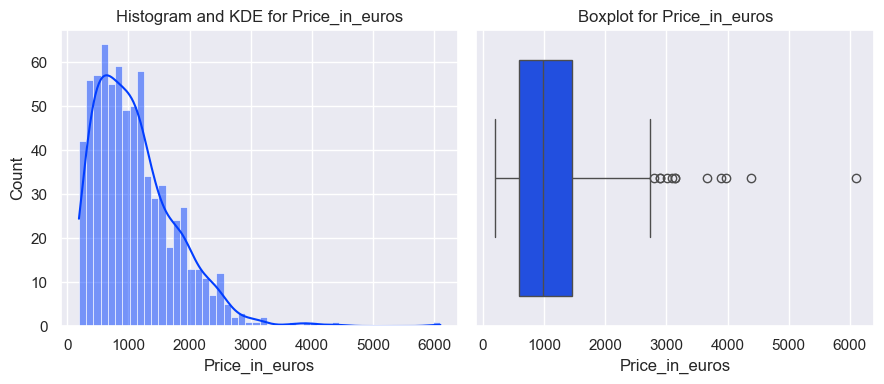

In [93]:
# Crear figura y subgráficas
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Graficar el histograma con KDE en la primera subgráfica
sns.histplot(train_set[target], kde=True, bins=50, ax=axs[0])
axs[0].set_title(f'Histogram and KDE for {target}')
axs[0].set_xlabel(target)

# Graficar el boxplot horizontal en la segunda subgráfica
sns.boxplot(x=train_set[target], ax=axs[1], orient='h')
axs[1].set_title(f'Boxplot for {target}')
axs[1].set_xlabel(target)

# Ajustar el layout
plt.tight_layout()
plt.show()


Hay varios valores outliers por arriba, que si los dejo en el modelo puede que modifiquen la métrica que estoy buscando. Los voy a eliminar a riesgo de no aprender nada de los ordenadores más caros del set.

NOTA: He encontrado que esto se podría resolver a posteriori con `RobustScaler()`.

In [94]:
# Calcular los cuartiles y el IQR
Q1 = train_set[target].quantile(0.25)
Q3 = train_set[target].quantile(0.75)
IQR = Q3 - Q1

# Definir límite superior
upper_bound = Q3 + 1.5 * IQR
print('Precio límite de los outliers:', upper_bound, '€.')

Precio límite de los outliers: 2753.0 €.


Viendo el KDE no voy a ser tan estricto como eliminar los outliers que justo caigan en el "upper bound", si no que voy a darle un margen un poco por encima.

Con un filtro (upper_limit) en 3500 € tan solo voy a dejar fuera 5 muestras, de las 729.

Ojo porque este filtro (eliminar outliers) solo lo voy a aplicar en el *train_set*, porque en el test me pueden venir ordenadores de cualquier precio.

In [95]:
upper_limit = 3500

# Solo dejo fuera del set 5 valores.
# display(train_set[train_set[target] >= upper_limit])

# Filtro train_set eliminando lo valores de los outliers. 
train_set = train_set[~(train_set[target] >= upper_limit)]
train_set.describe()

,Inches,Price_in_euros,RamGB,WeightKg
count,724.000000,724.000000,724.000000,724.000000
mean,14.987017,1081.008301,8.046961,2.021374
std,1.420770,612.069184,4.274535,0.651501
min,10.100000,191.900000,2.000000,0.690000
25%,14.000000,597.750000,4.000000,1.497500
50%,15.600000,979.000000,8.000000,2.040000
75%,15.600000,1434.000000,8.000000,2.300000
max,17.300000,3149.000000,32.000000,4.600000


<Axes: xlabel='Price_in_euros', ylabel='Count'>

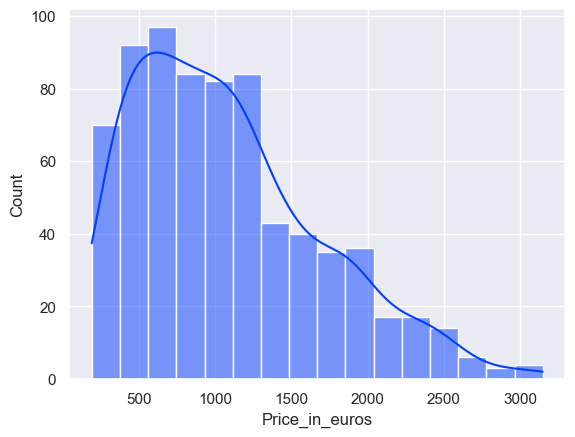

In [96]:
# Nueva densidad de probabilidad (tras eliminar outliers)
sns.histplot(train_set[target], kde=True)

No tiene una mala distribución el target, pero seguro que se puede mejorar...

A continuación muestro dos transformaciones no lineales que se pueden emplear en el target (como son la logaritmica y la raíz cuadrada).

<Axes: xlabel='Price_in_euros', ylabel='Count'>

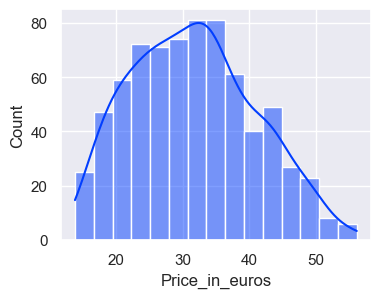

In [97]:
# Transformación raíz cuadrada.
plt.figure(figsize=(4, 3))
sns.histplot(np.sqrt(train_set[target]), kde=True)

En esta ocasión prefiero aplicar una `tranformación logarítmica al target`, a ver si de esta forma mejoro los resultados de las estimaciones. Pero cuidado, porque después habrá que hacer la des-transformación.

`Box-Cox` y `Yeo-Johnson` a través de Power Transform probablemente sean más convenientes, pero de momento los dejo fuera de mi análisis por tiempo. Además de momento voy a apostar por algoritmos de boosting en el que las distancias y distribución tienen menor importancia.

<Axes: xlabel='log_price_euros', ylabel='Count'>

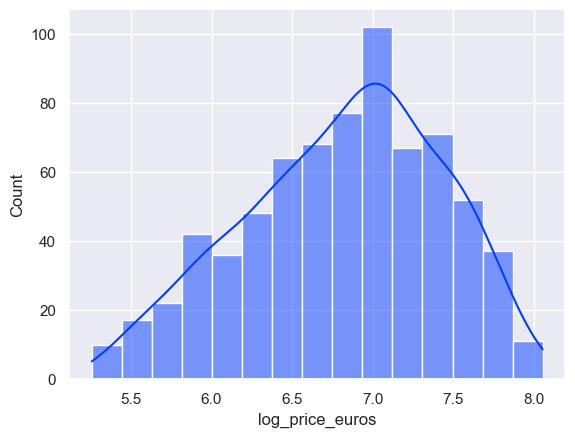

In [98]:
# Transformación logarítmica
train_set['log_price_euros'] = np.log(train_set['Price_in_euros'])
test_set['log_price_euros'] = np.log(test_set['Price_in_euros'])

train_set.drop(['Price_in_euros'], axis=1, inplace=True)
test_set.drop(['Price_in_euros'], axis=1, inplace=True)

sns.histplot(train_set['log_price_euros'], kde=True)

### Análisis de la única variable numérica.

Parece que tiene una distribución conveniente para los modelos, así que no voy a aplicar el logaritmo.

<Axes: xlabel='WeightKg', ylabel='Count'>

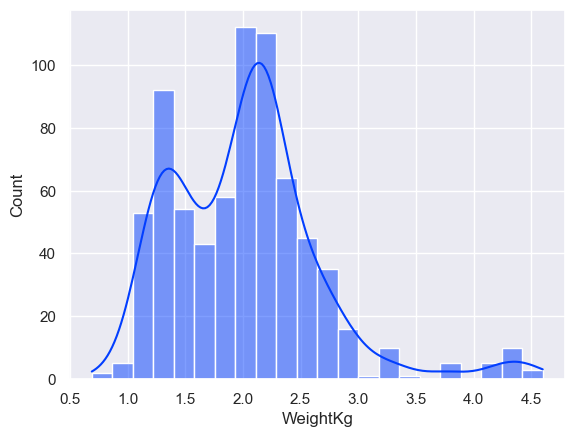

In [99]:
sns.histplot(train_set['WeightKg'], kde=True)

## 4.3 Análisis bivariante

Voy a inspeccionar visualmente aquellas variables en las que se pueda ver algo.

Definamos primero las variables categóricas de las numéricas.

In [15]:
# Definir variables numéricas, categóricas y categóricas con alta cardinalidad
target = 'log_price_euros'
num_features = ['WeightKg']
cat_features_high_card = ['Product', 'Cpu', 'Gpu']
cat_features = [col for col in train_set.columns.to_list() if col not in (num_features + [target])]

print(target)
print(num_features)
print(cat_features_high_card)
print(cat_features)


log_price_euros
['WeightKg']
['Product', 'Cpu', 'Gpu']
['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys', 'RamGB']


#### Inspección de las variables categóricas.


In [16]:
# Variable para almacenar el máximo número de valores únicos
cat_max_nunique = 0  

for feature in cat_features:
    if feature not in cat_features_high_card:
        unique_values = train_set[feature].nunique()
        print(f'{feature}: {unique_values} valores únicos')
        
        # Actualizar el valor máximo si el actual es mayor
        if unique_values > cat_max_nunique:
            cat_max_nunique = unique_values

print(f'El número más alto de valores únicos es: {cat_max_nunique}')


Company: 17 valores únicos
TypeName: 6 valores únicos
Inches: 15 valores únicos
ScreenResolution: 33 valores únicos
Memory: 32 valores únicos
OpSys: 9 valores únicos
RamGB: 7 valores únicos
El número más alto de valores únicos es: 33


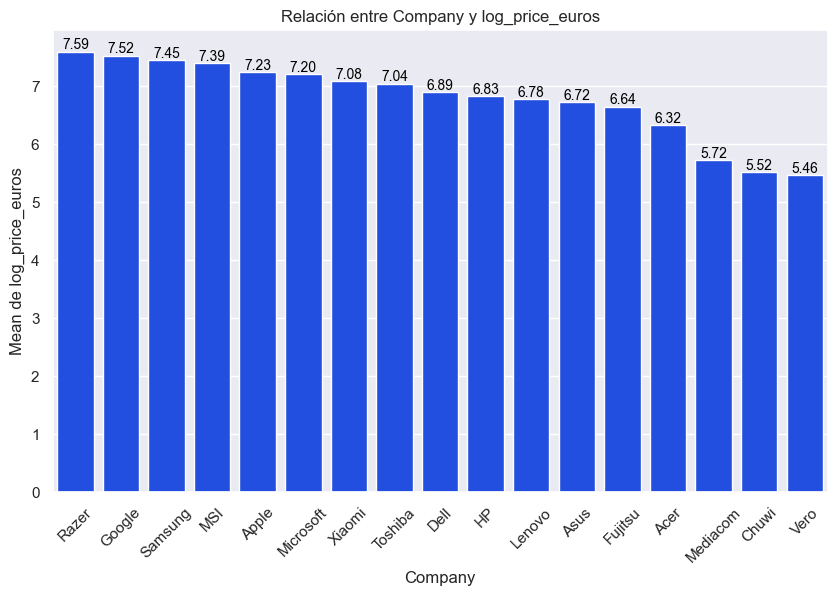

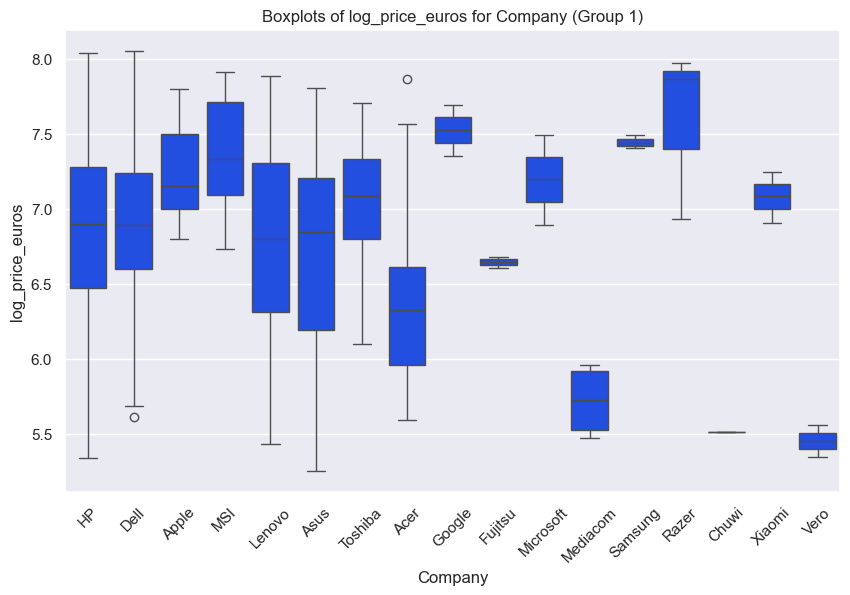

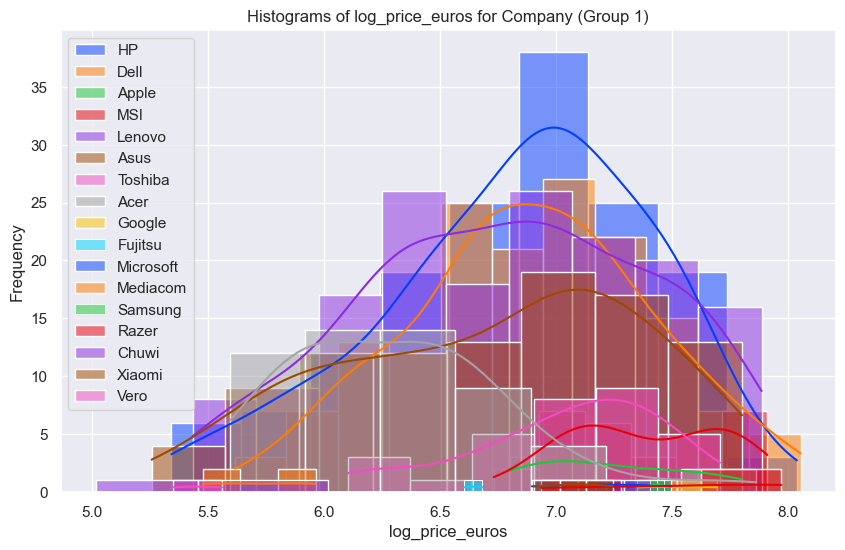

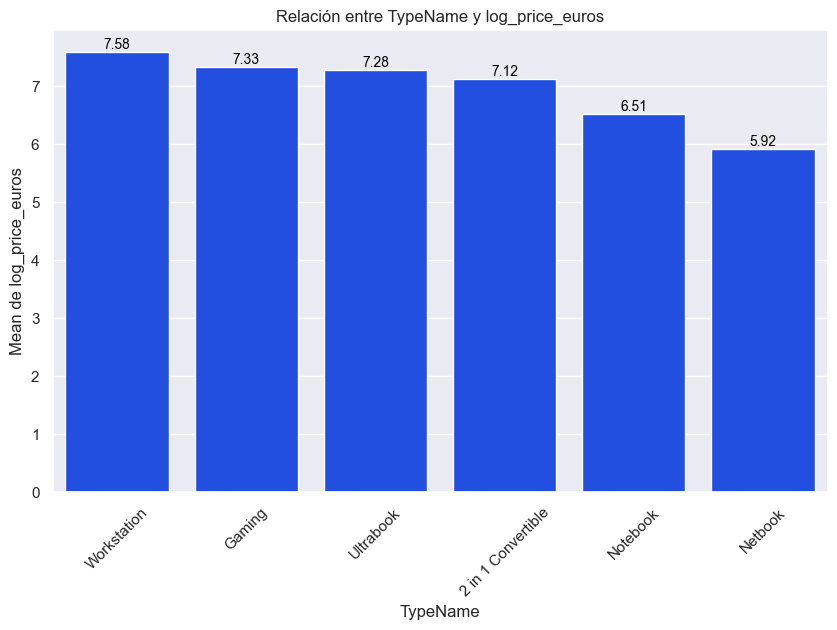

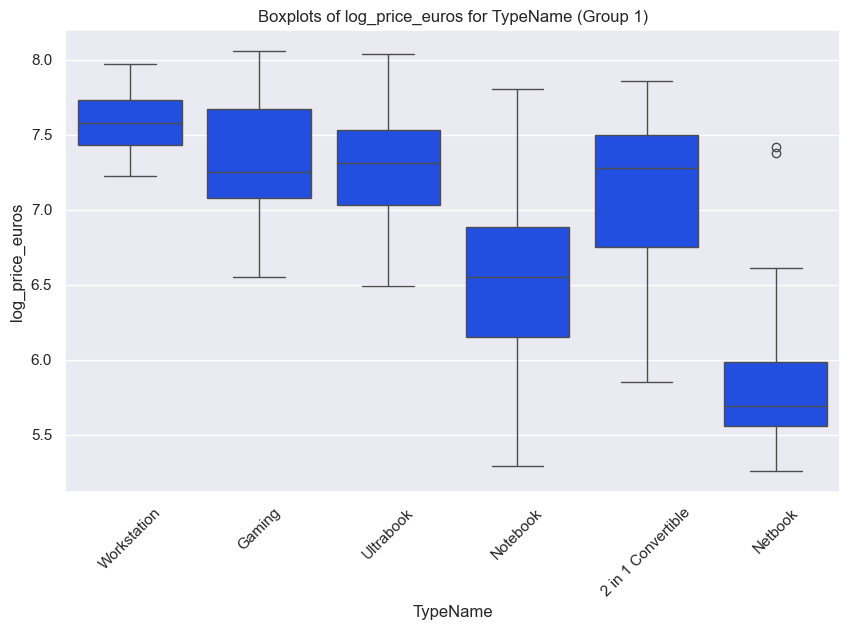

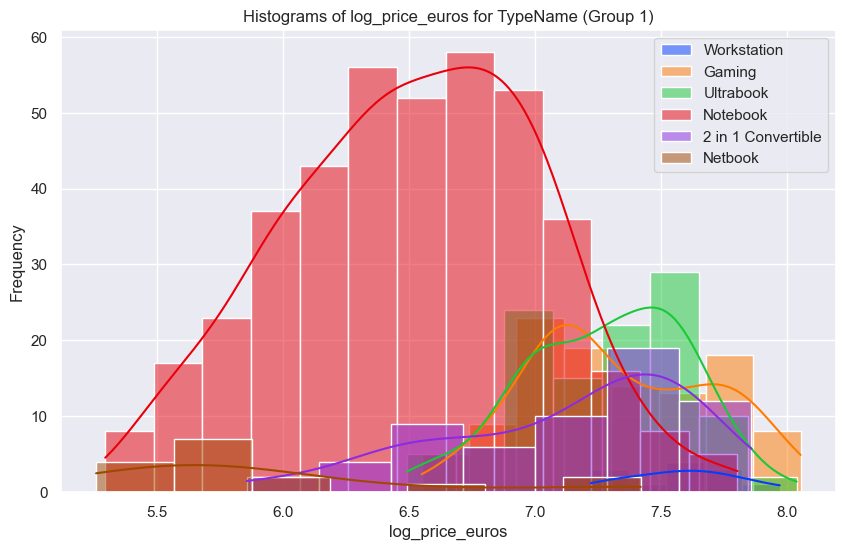

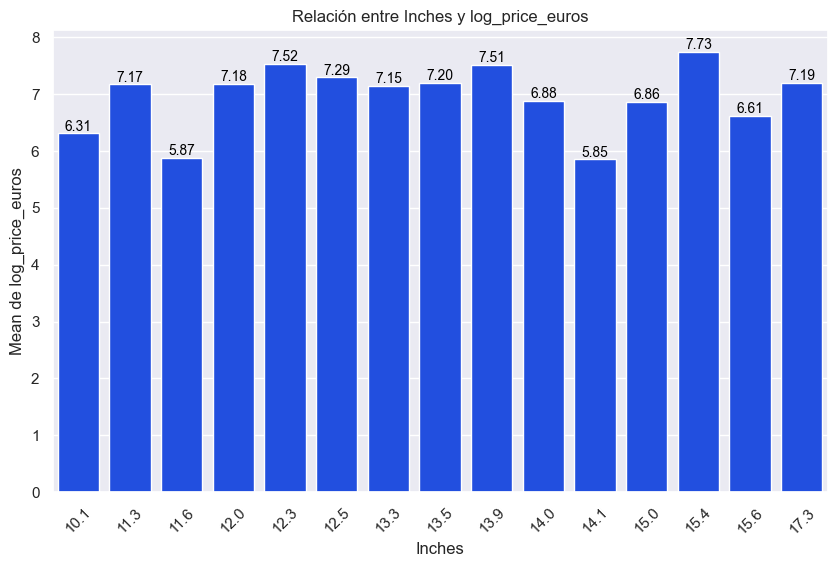

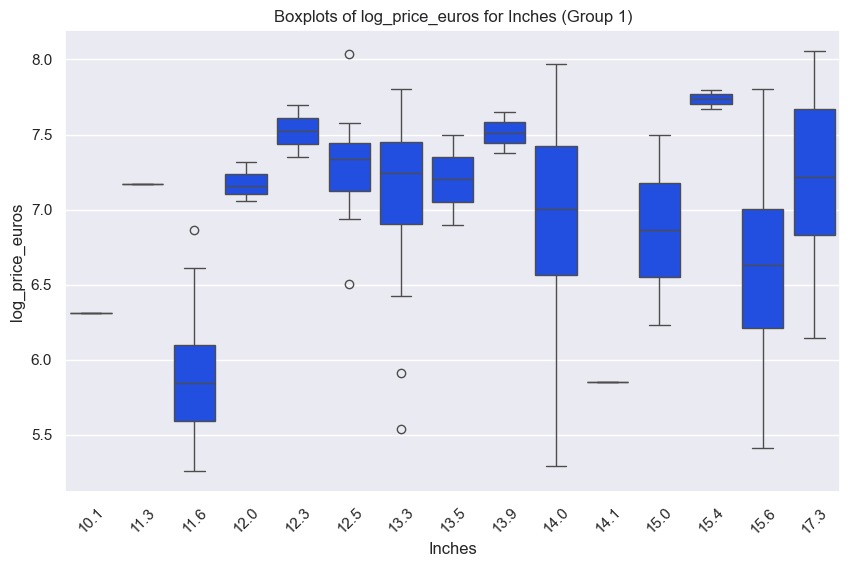

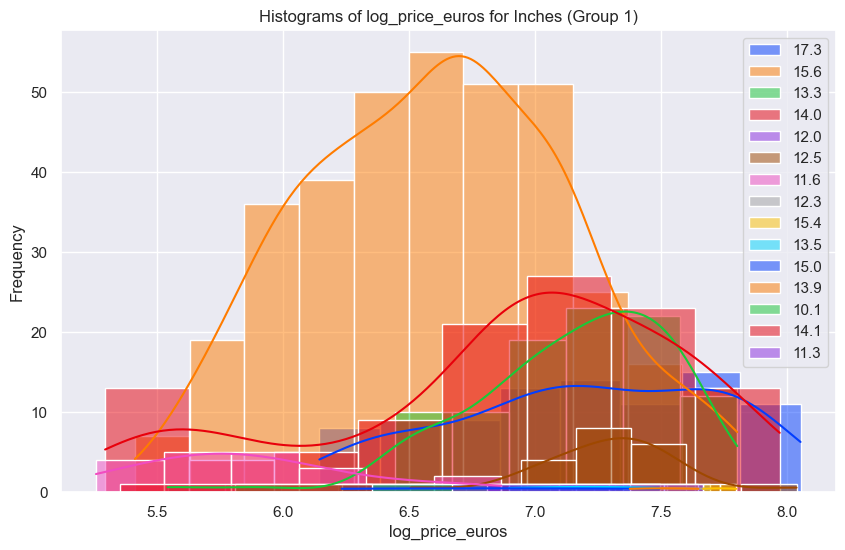

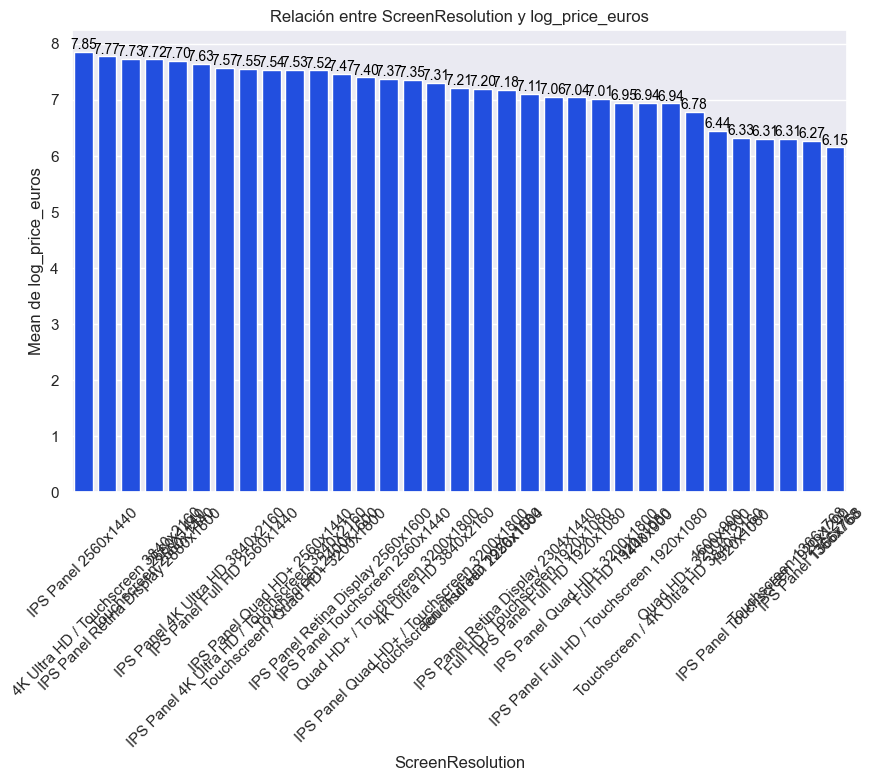

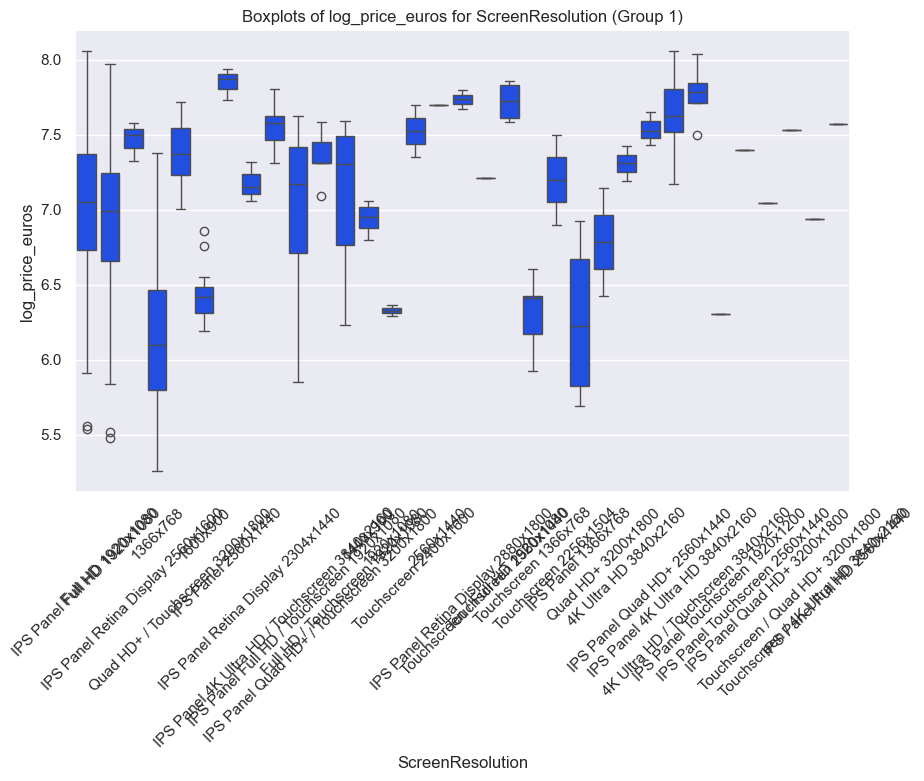

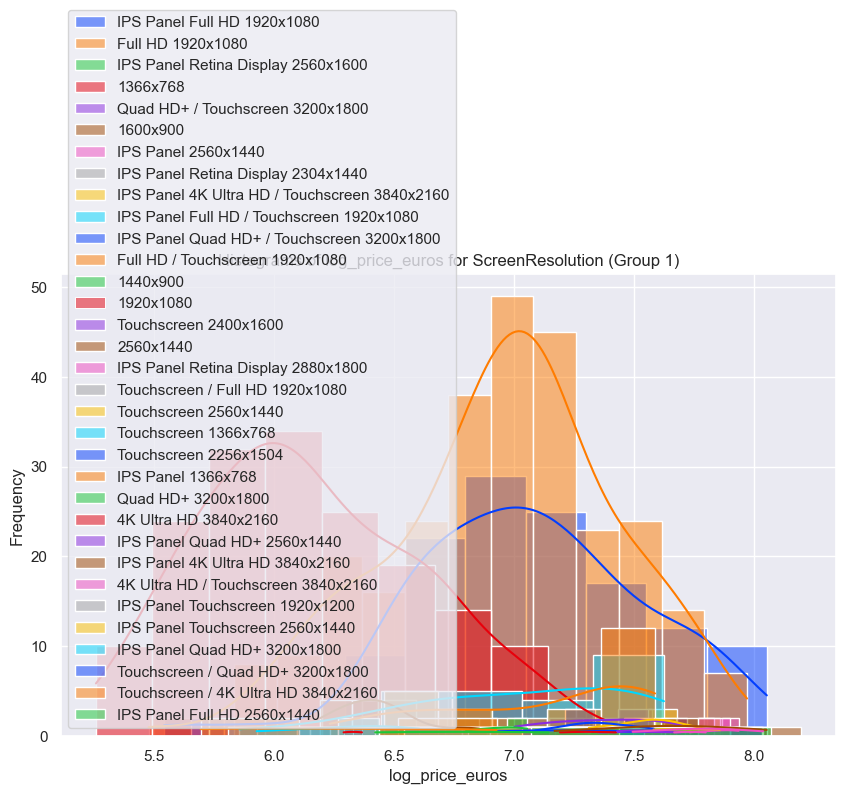

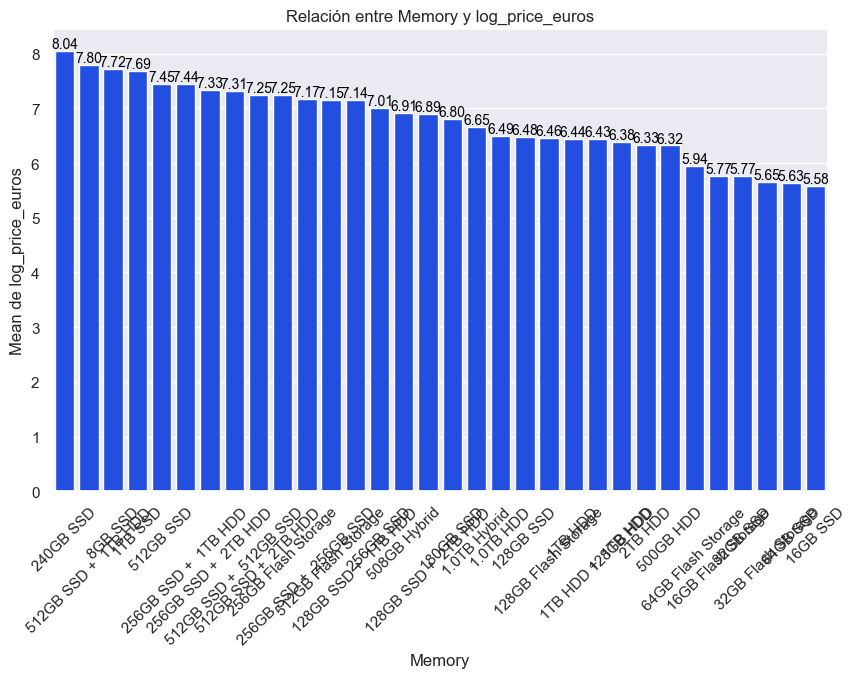

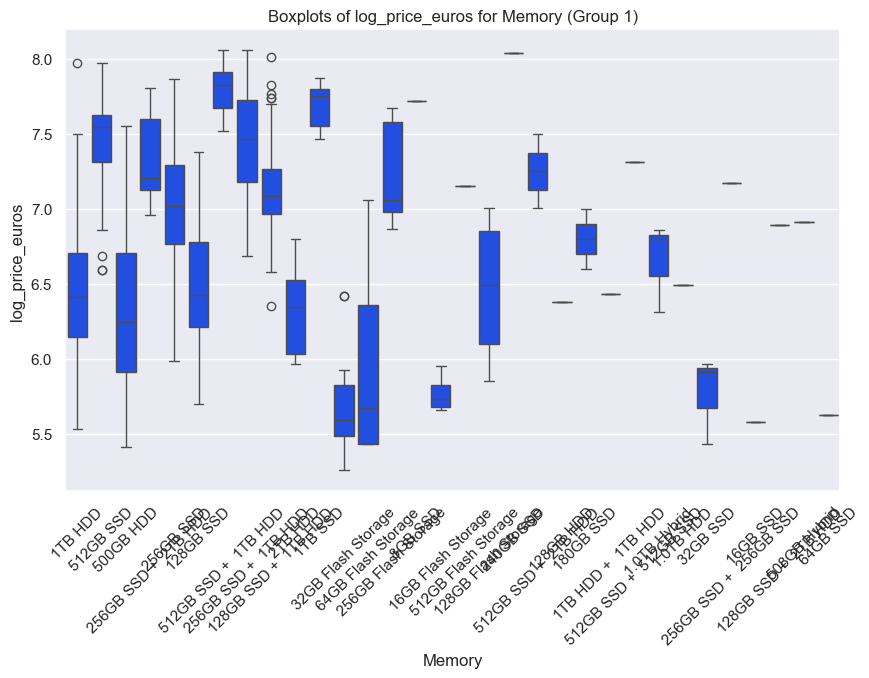

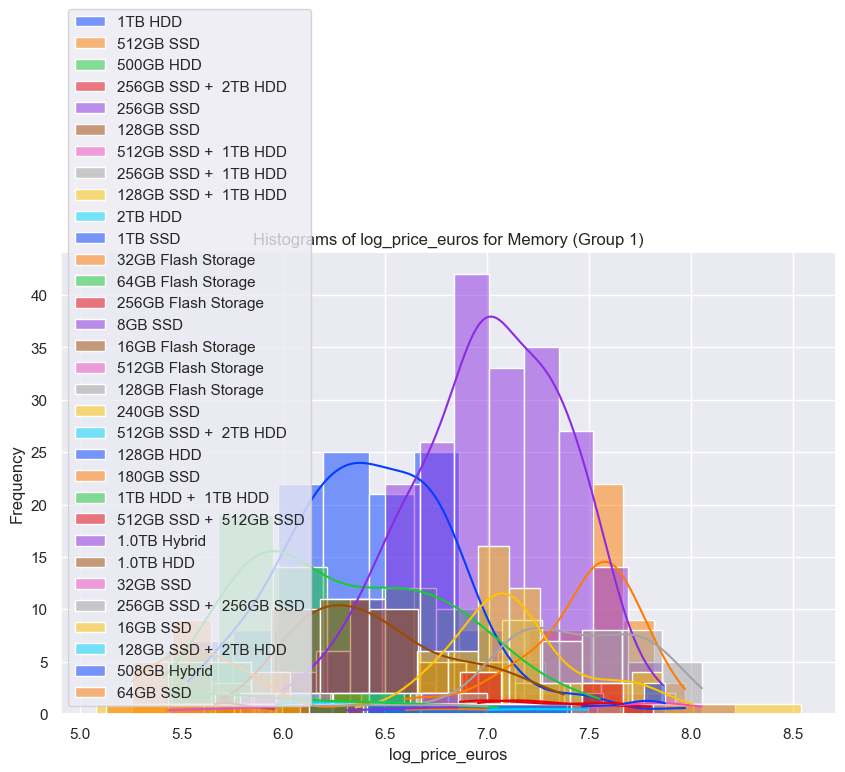

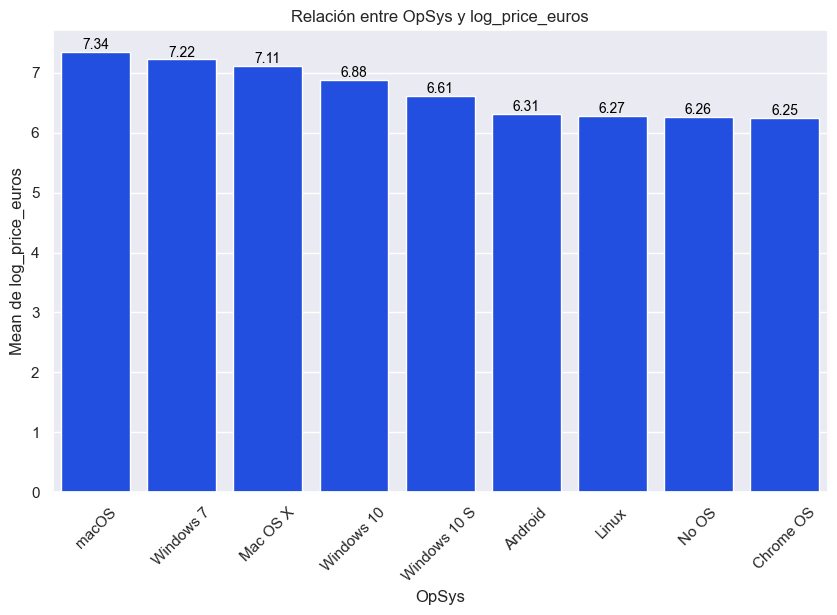

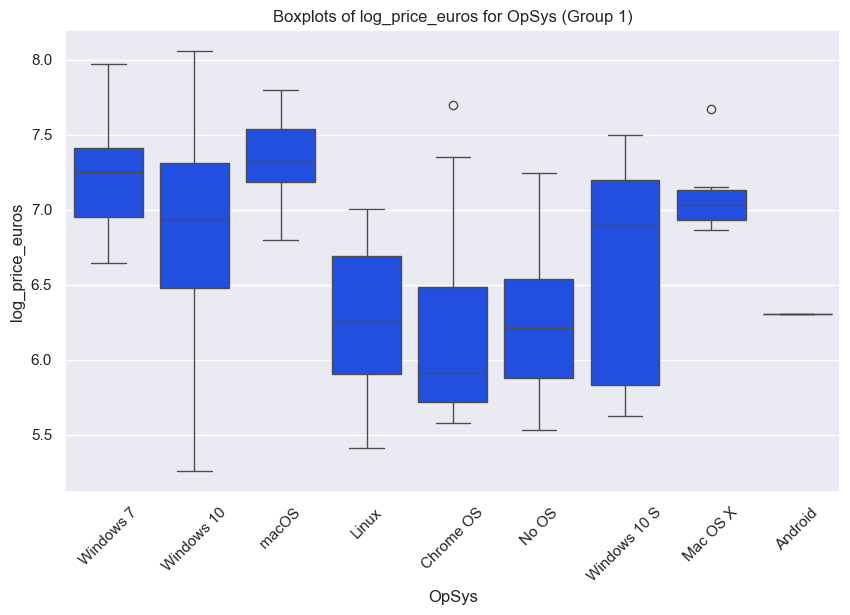

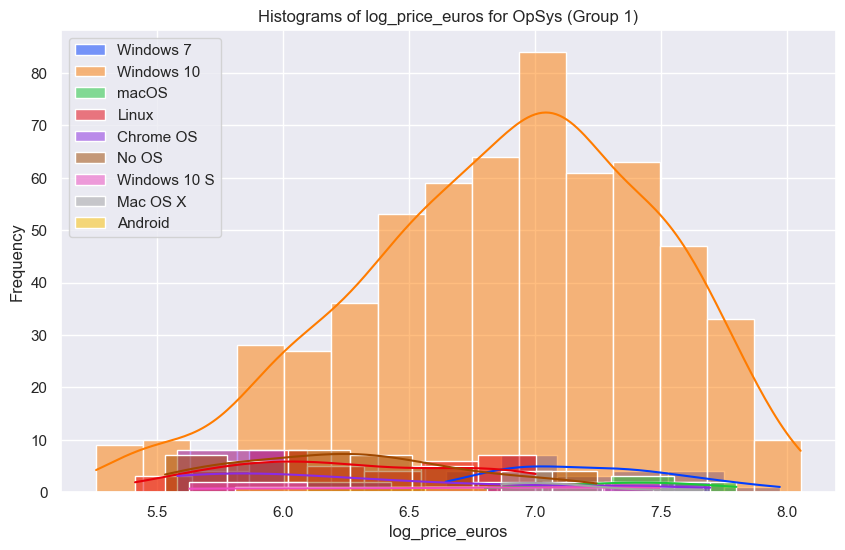

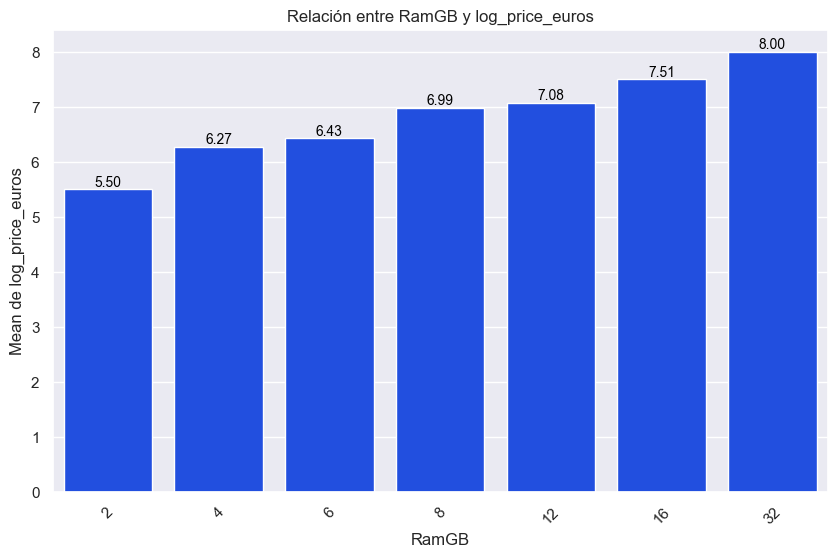

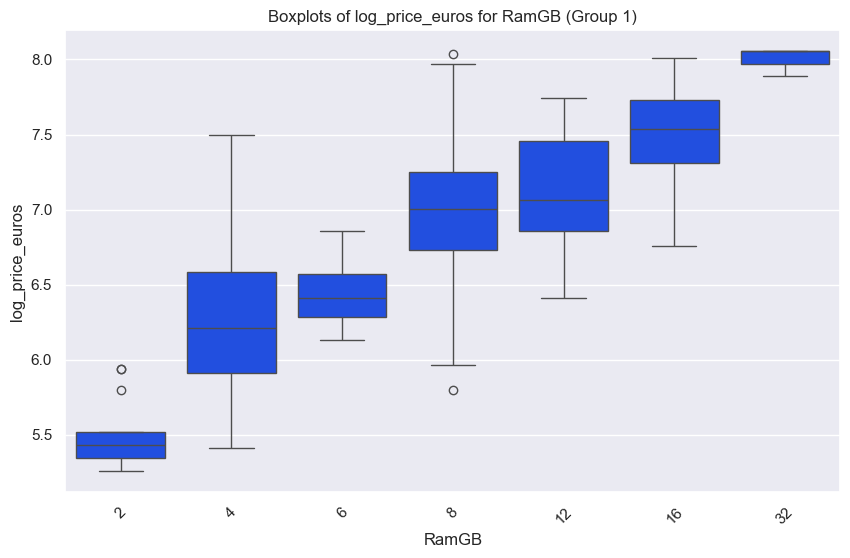

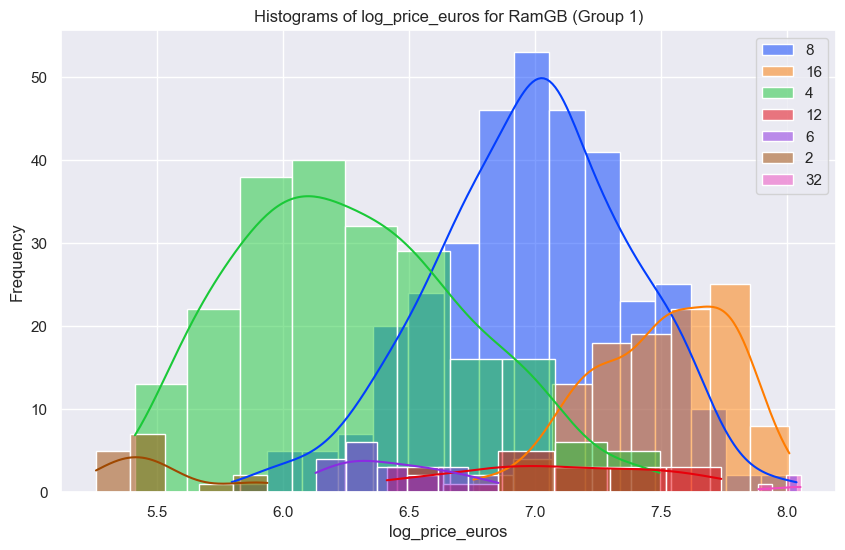

In [17]:
for feature in cat_features:
    if feature not in cat_features_high_card:
        viz.plot_categorical_numerical_relationship(train_set, feature, target, group_size=cat_max_nunique)
        viz.boxplots_grouped(train_set, feature, target, group_size=cat_max_nunique)
        viz.plot_histograms_grouped(train_set, feature, target, group_size=cat_max_nunique)
    

Es algo complicado y lento de analizar visualmente pero todas las features me parecen interesantes.

Lo único que puedo resaltar es que hay algunos valores de outliers, condicionados a la clase a la que pertecen, que también podría eliminar para que mi modelo generalice mejor, pero de nuevo, `aquí no voy a eliminar más outliers`. Puede que en futuros modelos sí lo haga.

Por ejemplo, he visto outliers simbólicos asociados a:
- RamGB = 2, 4
- OpSys = Chrome OS
- Inches = 13.3
- Company = Acer
- TypeName = Notebook

Voy a hacer ahora un análisis de correlación con el *target* de las variables representadas numéricamente (que no es lo mismo que decir que las considero numéricas), y de colinealidad, porque puedo sacar nuevas conclusiones.

<Axes: >

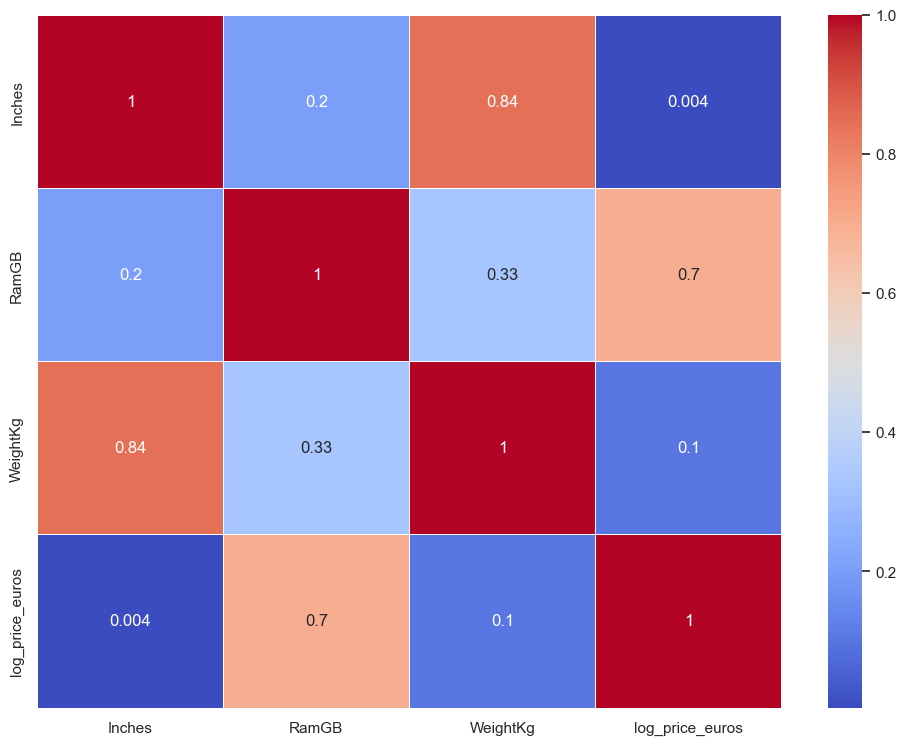

In [18]:
corr_matrix = train_set.corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5)

Conclusiones de esta matriz de correlaciones:

- Si trato "RamGB" como una numérica discreta, encuentro que tiene una alta correlación con "log_price_euros", y puede que sea más conveniente que tratarla como una categórica.

- A su vez, si hago la anterior suposición, encuentro que "RamGB" y "WeightKg" tienen una relativamente alta colinealidad (0.33), lo que puede hacer que sea con dependedientes el resultado de la regresión mejore eliminando esta segunda. Aunque no tanto como "WeightKg" e "Inches" que tienen un colinealidad de 0.84.

Todas las conclusiones que he sacado hasta este punto van a servir para probar diferentes features, tratarlas de diferente forma y probar varios modelos de regresión.

# 5. Transformación de features


In [19]:
print(cat_features)
print(num_features)

['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys', 'RamGB']
['WeightKg']


In [20]:
X_train = train_set.drop(columns=[target])
X_test = test_set.drop(columns=[target])

y_train = train_set[target]
y_test = test_set[target]

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724 entries, 1118 to 418
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           724 non-null    object 
 1   Product           724 non-null    object 
 2   TypeName          724 non-null    object 
 3   Inches            724 non-null    float64
 4   ScreenResolution  724 non-null    object 
 5   Cpu               724 non-null    object 
 6   Memory            724 non-null    object 
 7   Gpu               724 non-null    object 
 8   OpSys             724 non-null    object 
 9   RamGB             724 non-null    int32  
 10  WeightKg          724 non-null    float64
dtypes: float64(2), int32(1), object(8)
memory usage: 65.0+ KB


Tengo demasiadas variables categóricas, y algunas de ellas con demasidas categorías como para hacer un One-Hot Encoder. Creo que favorecería la "maldición de la dimensionalidad.

Otras estrategias:
- Ordinal Encoder. Algunas variables categóricas sí parecen ser ordinales, pero ordenarlas a mano me va a llevar bastante tiempo.

- LabelEncoder. No se si esto es "legal" porque dice que solo se debería aplicar sobre el target, pero parace que me podría servir para codificar las features. De nuevo acepta cierta ordinalidad pero parece que sí la tengo con algunas variables. Aunque para esto ya uso el OrdinalEncoder.

- Target Encoding. Este método asigna un valor numérico a cada categoría en función del promedio del target para esa categoría. Puede ser útil para features de alta cardinalidad. Sin embargo, debe usarse con precaución para evitar el overfitting.

- Frecuency/Count Encoding. Este método reemplaza las categorías por la frecuencia de cada categoría. Es útil en casos donde hay muchas categorías y no se quiere aumentar el número de columnas como con One-Hot Encoding.

- Hashing Encoding. El Hashing Trick es otra opción para variables de alta cardinalidad. Se basa en aplicar una función hash a las categorías para reducirlas a un número fijo de columnas, lo que ayuda a controlar el tamaño de las características.

De momento no voy a hacer tranformaciones porque voy a usar modelos a los que no les importa estar estandarizados. Y voy a intentar aprovecharme de algoritmos que usen directamente categóricas.

### Ordinal Encoding

In [22]:
# Ordinal Encoding
X_train_ord_encoded = X_train.copy()
X_test_ord_encoded = X_test.copy()

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 

X_train_ord_encoded[cat_features] = ord_encoder.fit_transform(X_train_ord_encoded[cat_features])
X_test_ord_encoded[cat_features] = ord_encoder.transform(X_test_ord_encoded[cat_features])


Vamos a encontrar que como "Inches" y "WeightKg" estaban representadas numéricamente ha hecho una codificación ordinal ordenando los valores, lo cual tiene sentido en este caso, porque más pulgadas o mas RAM va a asociado a mayor precio, tal y como hemos visto en el análisis bivariante.

In [23]:
X_train_ord_encoded.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
laptop_ID,,,,,,,,,,,
1118,7.0,389.0,5.0,14.0,14.0,73.0,10.0,2.0,7.0,3.0,3.00
153,4.0,152.0,1.0,13.0,8.0,80.0,25.0,60.0,5.0,5.0,2.56
275,1.0,192.0,4.0,6.0,20.0,52.0,25.0,46.0,8.0,3.0,1.37
1100,7.0,66.0,3.0,9.0,8.0,54.0,22.0,37.0,7.0,1.0,1.54
131,4.0,155.0,3.0,14.0,8.0,84.0,18.0,6.0,5.0,5.0,2.80


In [24]:
X_test_ord_encoded.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
laptop_ID,,,,,,,,,,,
451,7.0,-1.0,1.0,13.0,14.0,80.0,5.0,60.0,5.0,3.0,2.20
802,8.0,-1.0,0.0,13.0,7.0,60.0,15.0,25.0,5.0,3.0,2.08
723,8.0,-1.0,3.0,9.0,14.0,60.0,15.0,53.0,5.0,3.0,1.87
682,7.0,-1.0,0.0,9.0,13.0,46.0,4.0,58.0,5.0,1.0,1.63
1306,2.0,371.0,3.0,13.0,0.0,24.0,22.0,30.0,5.0,1.0,2.20


Estandarizado para los pesos de cada columna.

Aunque estando todo en el orden de las unidades, decenas o centenas no creo que esto sea tan determinante.

### StandarsScaler y RobustScaler sobre OrdinalEncoded

In [25]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# Standard Scaler
X_train_ord_std = pd.DataFrame(std_scaler.fit_transform(X_train_ord_encoded), columns=X_train_ord_encoded.columns)
X_test_ord_std = pd.DataFrame(std_scaler.transform(X_test_ord_encoded), columns=X_test_ord_encoded.columns)

# Robust Scaler
X_train_ord_rob = pd.DataFrame(rob_scaler.fit_transform(X_train_ord_encoded), columns=X_train_ord_encoded.columns)
X_test_ord_rob = pd.DataFrame(rob_scaler.transform(X_test_ord_encoded), columns=X_test_ord_encoded.columns)

In [26]:
X_train_ord_std.describe()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
count,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02
mean,-1.962825e-17,3.434944e-17,4.661710e-17,2.797026e-16,-4.907063e-17,-1.030483e-16,1.275836e-16,-2.208178e-17,-1.570260e-16,-3.680297e-17,4.318216e-16
std,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00
min,-1.690405e+00,-1.757258e+00,-2.155917e+00,-3.235743e+00,-1.271630e+00,-3.011416e+00,-2.264919e+00,-2.626763e+00,-4.635568e+00,-1.891795e+00,-2.044962e+00
25%,-5.158818e-01,-7.580914e-01,-5.033135e-01,-5.502123e-01,-9.641282e-01,-4.568226e-01,-7.230277e-01,-3.920617e-01,2.017788e-01,-1.179173e+00,-8.046595e-01
50%,3.650107e-01,-9.198011e-02,3.229880e-01,6.433569e-01,-4.162315e-02,2.959802e-01,4.791789e-02,-7.281865e-02,2.017788e-01,2.460711e-01,2.860865e-02
75%,6.586415e-01,8.480256e-01,3.229880e-01,6.433569e-01,7.271310e-01,7.402572e-01,8.188634e-01,7.784961e-01,2.017788e-01,2.460711e-01,4.279630e-01
max,3.007688e+00,1.783649e+00,1.975591e+00,9.417492e-01,3.648397e+00,1.480719e+00,2.514944e+00,2.237893e+00,3.104187e+00,2.383937e+00,3.960713e+00


In [27]:
X_test_ord_std.describe()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,-0.101910,-0.674037,-0.015660,-0.087134,0.126411,-0.331187,-0.017802,-0.145257,-0.110138,0.004636,-0.033149
std,0.987453,1.209072,1.078866,1.111928,1.178529,1.303261,1.069522,1.189906,1.298745,1.025631,1.007511
min,-1.984036,-1.766023,-2.155917,-3.534135,-1.425381,-3.060780,-2.419108,-2.687571,-4.635568,-2.604416,-2.044962
25%,-0.956328,-1.766023,-1.329615,-0.550212,-0.887253,-0.888759,-0.723028,-0.741709,0.201779,-1.179173,-0.877618
50%,0.365011,-1.257675,0.322988,0.643357,-0.041623,-0.049569,0.047918,-0.072819,0.201779,0.246071,-0.032830
75%,0.658642,0.302428,0.322988,0.643357,0.880882,0.740257,0.818863,0.900112,0.201779,0.246071,0.435643
max,2.420426,1.739826,1.975591,0.941749,3.648397,1.431355,2.206565,2.237893,3.104187,2.383937,3.684237


### Target Encoding

Calcular el promedio del target para cada categoría, y reemplazo las categorías con el promedio en el conjunto de entrenamiento y test.

In [28]:
# Redefinir catagorías de alta cardinalidad

cat_features_high_card = ['Product', 'Cpu', 'Gpu', 'ScreenResolution', 'Memory']
cat_features_low_card = [col for col in cat_features if col not in cat_features_high_card]

# Target Encoding
X_train_target_encoded = X_train.copy()
X_test_target_encoded = X_test.copy()

for feature in cat_features_high_card:
    # Calcular el promedio del objetivo (price) por categoría
    target_mean = pd.concat([X_train, y_train], axis=1).groupby(feature)[target].mean()
    # Reemplazar las categorías con el promedio en el conjunto de entrenamiento
    X_train_target_encoded[feature] = X_train_target_encoded[feature].map(target_mean)
    X_test_target_encoded[feature] = X_test_target_encoded[feature].map(target_mean)


# Ordinal Encoding sobre las categóricas representadas con "object"
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
X_train_target_encoded[['Company', 'TypeName', 'OpSys']] = ord_encoder.fit_transform(X_train_target_encoded[['Company', 'TypeName', 'OpSys']])
X_test_target_encoded[['Company', 'TypeName', 'OpSys']] = ord_encoder.transform(X_test_target_encoded[['Company', 'TypeName', 'OpSys']])

# Resultados
display(X_train_target_encoded.head())
display(X_test_target_encoded.head())

# Standard Scaler
std_scaler = StandardScaler()
X_train_tar_enc_std = pd.DataFrame(std_scaler.fit_transform(X_train_target_encoded), columns=X_train_target_encoded.columns)
X_test_tar_enc_std = pd.DataFrame(std_scaler.transform(X_test_target_encoded), columns=X_test_target_encoded.columns)

display(X_train_tar_enc_std)
display(X_test_tar_enc_std)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
laptop_ID,,,,,,,,,,,
1118,7.0,7.762963,5.0,17.3,7.058754,7.286759,6.435457,7.972121,7.0,8,3.00
153,4.0,7.048396,1.0,15.6,6.945608,7.386643,7.447738,7.053315,5.0,16,2.56
275,1.0,7.574296,4.0,13.3,7.467730,7.580138,7.447738,7.580138,8.0,8,1.37
1100,7.0,7.286880,3.0,14.0,6.945608,6.957931,6.320850,6.846626,7.0,4,1.54
131,4.0,7.100552,3.0,17.3,6.945608,7.048784,7.331771,6.740237,5.0,16,2.80


,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
laptop_ID,,,,,,,,,,,
451,7.0,NaN,1.0,15.6,7.058754,7.386643,7.143881,7.053315,5.0,8,2.20
802,8.0,NaN,0.0,15.6,7.112858,6.733530,7.013454,6.683361,5.0,8,2.08
723,8.0,NaN,3.0,14.0,7.058754,6.733530,7.013454,6.334877,5.0,8,1.87
682,7.0,NaN,0.0,14.0,7.010559,6.340362,6.480061,6.757570,5.0,4,1.63
1306,2.0,5.910797,3.0,15.6,6.152393,5.722593,6.320850,5.790487,5.0,4,2.20


,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
0,0.365011,1.596396,1.975591,1.629105,0.583975,0.888498,-0.795011,2.383566,2.136717,-0.010994,1.503148
1,-0.515882,0.393944,-1.329615,0.431743,0.313689,1.076335,1.329327,0.492065,0.201779,1.861848,0.827317
2,-1.396774,1.278911,1.149290,-1.188217,1.560945,1.440213,1.329327,1.576610,3.104187,-0.010994,-1.000497
3,0.365011,0.795257,0.322988,-0.695186,0.313689,0.270119,-1.035521,0.066564,2.136717,-0.947415,-0.739380
4,-0.515882,0.481709,0.322988,1.629105,0.313689,0.440974,1.085964,-0.152454,0.201779,1.861848,1.195952
...,...,...,...,...,...,...,...,...,...,...,...
719,0.365011,-1.431554,0.322988,-0.695186,-1.581158,-1.565619,-1.018373,-1.774136,0.201779,-0.010994,-0.124989
720,0.658642,-0.517840,0.322988,0.431743,0.313689,-0.578703,0.417953,-0.152454,0.201779,-0.479204,0.274365
721,-0.515882,1.004381,1.149290,-1.751682,0.313689,1.155074,0.417953,0.177114,0.201779,1.861848,-1.292333
722,0.658642,-1.760632,0.322988,0.431743,-1.581158,-1.922402,-0.795011,-2.094987,0.201779,-0.947415,0.274365


,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,RamGB,WeightKg
0,0.365011,NaN,-1.329615,0.431743,0.583975,1.076335,0.691664,0.492065,0.201779,-0.010994,0.274365
1,0.658642,NaN,-2.155917,0.431743,0.713220,-0.151877,0.417953,-0.269542,0.201779,-0.010994,0.090048
2,0.658642,NaN,0.322988,-0.695186,0.583975,-0.151877,0.417953,-0.986950,0.201779,-0.010994,-0.232508
3,0.365011,NaN,-2.155917,-0.695186,0.468847,-0.891249,-0.701407,-0.116770,0.201779,-0.947415,-0.601142
4,-1.103143,-1.520375,0.322988,0.431743,-1.581158,-2.052995,-1.035521,-2.107658,0.201779,-0.947415,0.274365
...,...,...,...,...,...,...,...,...,...,...,...
178,0.365011,-1.270277,0.322988,0.431743,0.313689,-0.151877,-0.795011,0.177114,0.201779,-0.010994,-0.247867
179,-1.690405,NaN,-2.155917,-2.385579,NaN,-1.937845,-2.435654,-2.367202,-3.668098,-0.947415,-1.184814
180,0.658642,NaN,0.322988,-2.385579,-1.581158,-1.922402,-2.435654,-2.094987,0.201779,-1.415626,-1.338412
181,0.658642,NaN,0.322988,-0.695186,0.583975,0.534823,0.417953,-0.116770,0.201779,-0.010994,-0.232508


# 6. Instanciación de modelos

Para lograr que `ElasticNet` contemple las características de los modelos de Regresión Lineal, Ridge y Lasso a través de la búsqueda de hiperparámetros, voy a establecer un rango de valores de alpha y l1_ratio de tal manera que incluya los casos extremos que representen cada modelo:

- Regresión Lineal: alpha = 0 y l1_ratio = 0 (sin regularización).
- Ridge: alpha > 0 y l1_ratio = 0 (solo regularización L2).
- Lasso: alpha > 0 y l1_ratio = 1 (solo regularización L1).
- Elastic Net: cualquier combinación de alpha y l1_ratio entre 0 y 1.

In [29]:
# El número de niveles para "probar" lo pongo más alto que en clasificación porque el rango de valores de la target es mucho mayor

lin_reg = LinearRegression(n_jobs=-2)
lasso = Lasso(alpha=1, random_state=42)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=1, random_state=42)
gboost = GradientBoostingRegressor(random_state=42)
rf_reg = RandomForestRegressor(max_depth=7, random_state=42)
svr = SVR()
xgb = XGBRegressor(max_depth=7, random_state=42)
lgb = LGBMRegressor(max_depth=7, random_state=42, verbose=-100)
cat = CatBoostRegressor(depth=7, random_seed=42, verbose=False)

models = {'LinearRegression': lin_reg,
          'Lasso': lasso,
          'ElasticNet': elastic_net,
          'GradientBoost': gboost,
          'SVR': svr,
          'RandomForest': rf_reg,
          'XGBoost': xgb,
          'LightGB': lgb,
          'CatBoost': cat
}


In [30]:
# Diccionario con los X_train que he preparado
X_train_dict = {
    'OrdinalEncoder': X_train_ord_encoded,
    'OrdinalEncoder_StandardScaler': X_train_ord_std,
    'OrdinalEncoder_RobustScaler': X_train_ord_rob,
    'TargetEncoder': X_train_target_encoded,
    'TargetEncoder_StandardScaler': X_train_tar_enc_std
}

# Argumentos para cross_val_score
kwargs = {
    'scoring': 'neg_root_mean_squared_error',
    'cv': 5,
    'n_jobs': -2,
    'verbose': 0
}

# Inicializar un DataFrame vacío para almacenar los resultados
df_cv = pd.DataFrame(columns=X_train_dict.keys())

# Validación cruzada de modelos Baseline y almacenamiento de resultados
for model, estimator in models.items():
    rmse_scores = []
    for feature_set, X_train in X_train_dict.items():
        rmse = -cross_val_score(estimator, X_train, y_train, **kwargs).mean()
        rmse_scores.append(rmse)
    
    # Añadir los resultados al DataFrame
    df_cv.loc[model] = rmse_scores

# Mostrar el DataFrame final
display(df_cv)


,OrdinalEncoder,OrdinalEncoder_StandardScaler,OrdinalEncoder_RobustScaler,TargetEncoder,TargetEncoder_StandardScaler
LinearRegression,0.322659,0.322659,0.322659,0.114774,0.114774
Lasso,0.458560,0.609558,0.609558,0.495158,0.609558
ElasticNet,0.351345,0.369657,0.392704,0.242016,0.162631
GradientBoost,0.203325,0.202788,0.203611,0.115495,0.115491
SVR,0.426032,0.236667,0.238381,0.136269,0.131773
RandomForest,0.228502,0.227675,0.228546,0.119525,0.119541
XGBoost,0.202771,0.202771,0.202771,0.124776,0.124776
LightGB,0.202758,0.200709,0.199655,0.118398,0.117933
CatBoost,0.183298,0.183167,0.183215,0.110239,0.110238


Resulta que entre StandardScaler y RobusScaler no encuentro gran diferencia. Igual es porque ya he limpiado un poco el dataset de Outliers. Así que por el momento y por sencillez, voy a usar el StandardScaler.

Lo que sí es claro es que el Target Encoder más preciso ha mejorado bastante los resultados.


In [31]:
# Ejemplo de LGBMRegressor

# Entrenar modelo
lgb.fit(X_train_tar_enc_std, y_train)

# Predecir en el conjunto de TRAIN
y_pred = lgb.predict(X_train_tar_enc_std)
rmse = root_mean_squared_error(np.exp(y_train), np.exp(y_pred))
print(f"RMSE en el conjunto de train: {rmse}")

# Predecir en el conjunto de TEST
y_pred = lgb.predict(X_test_tar_enc_std)
rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(f"RMSE en el conjunto de test: {rmse}")

RMSE en el conjunto de train: 91.7528818930174
RMSE en el conjunto de test: 465.02293060851275


# 7. Optimización de hiperparámetros

Supongamos que me quedo con el modelo de ElasticNet. Pero encuentro que el modelo lineal es parecido.

### Random Forest

In [32]:
# RandomForestRegressor

kwargs = {
    'scoring': 'neg_root_mean_squared_error', 
    'cv': 10, 
    'verbose': 1,
    'n_jobs': -2
}

param_grid = {
    'n_estimators': [50, 100, 200],   
    'max_depth': [5, 10, 20],        
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 5],
    'max_features': [0.8, 1] ,
    'bootstrap': [True, False]  
}

# Aplicar GridSearchCV
forest_grid = GridSearchCV(estimator=rf_reg, 
                           param_grid=param_grid,
                           **kwargs)

# Entrenar modelo
forest_grid.fit(X_train_target_encoded, y_train)

# Guardar modelo
os.makedirs('models', exist_ok=True)
with open('./models/forest_grid_laptop_03.pkl', 'wb') as file:
    pickle.dump(forest_grid, file)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits


Mejores parámetros: {'bootstrap': True, 'max_depth': 20, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mejor RMSE: 0.11124273561328608
RMSE en el conjunto de test: 0.41872460835863134


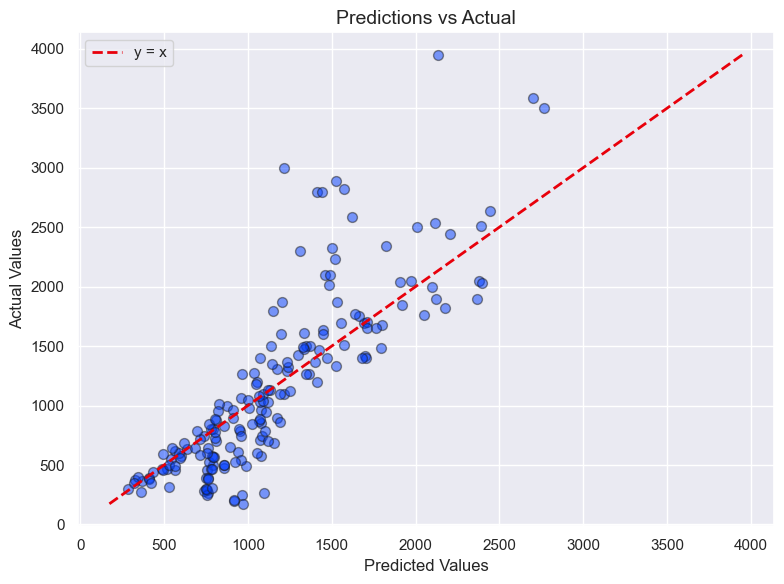

In [33]:
# Random Forest - Results
with open('./models/forest_grid_laptop_03.pkl', 'rb') as file:
    forest_grid = pickle.load(file)
    
print(f'Mejores parámetros: {forest_grid.best_params_}')
print(f'Mejor RMSE: {-forest_grid.best_score_}')

# Predecir en el conjunto de test
y_pred = forest_grid.best_estimator_.predict(X_test_target_encoded)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")

ml.plot_predictions_vs_actual(np.exp(y_test), np.exp(y_pred))

### ElasticNet

In [35]:
# # ElasticNet

# kwargs = {'scoring': 'neg_root_mean_squared_error', 
#           'cv': 5, 
#           'verbose': 1,
#           'n_jobs': -2
#           }

# param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # Fuerza de regularización
#     'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]  # L1 vs L2
# }

# grid_elastic = GridSearchCV(estimator=elastic_net, 
#                             param_grid=param_grid,
#                             **kwargs)

# # Entrenar modelo
# grid_elastic.fit(X_train_ord_std, y_train)

# # Resultados
# print(f'Mejores parámetros: {grid_elastic.best_params_}')
# print(f'Mejor RMSE: {-grid_elastic.best_score_}')

# # Predecir en el conjunto de test
# y_pred = grid_elastic.best_estimator_.predict(X_test_ord_std)
# rmse = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
# print(f"RMSE en el conjunto de test: {rmse}")

### LightGBM Regresor

In [41]:
# LGBMRegressor
kwargs = {
    'scoring': 'neg_root_mean_squared_error', 
    'cv': 10, 
    'verbose': 1,
    'n_jobs': -5
}

# Definimos la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],   
    'max_depth': [5, 7, 10],        
    'min_child_samples': [20, 30, 50], 
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'boosting_type': ['gbdt', 'dart'],
    'bagging_fraction': [0.8, 1.0],
    'feature_fraction': [0.8, 1.0]
}

# Aplicar GridSearchCV
lgb_grid = GridSearchCV(estimator=lgb, 
                        param_grid=param_grid,
                        **kwargs)

# Entrenar modelo. Con el estandarizado porque creo que mejora la eficiencia de cálculo
lgb_grid.fit(X_train_tar_enc_std, y_train)

# Guardar modelo
os.makedirs('models', exist_ok=True)
with open('./models/lgb_grid_laptop_03.pkl', 'wb') as file:
    pickle.dump(lgb_grid, file)

# Mostrar los mejores parámetros y score
print(f"Mejores hiperparámetros: {lgb_grid.best_params_}")
print(f"Mejor score: {-lgb_grid.best_score_}")


Fitting 10 folds for each of 1944 candidates, totalling 19440 fits
Mejores hiperparámetros: {'bagging_fraction': 0.8, 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 1, 'n_estimators': 200}
Mejor score: 0.1136785259743821


Mejores parámetros: {'bagging_fraction': 0.8, 'boosting_type': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 1, 'n_estimators': 200}
Mejor RMSE: 0.1136785259743821
RMSE en el conjunto de test: 0.388295524861769


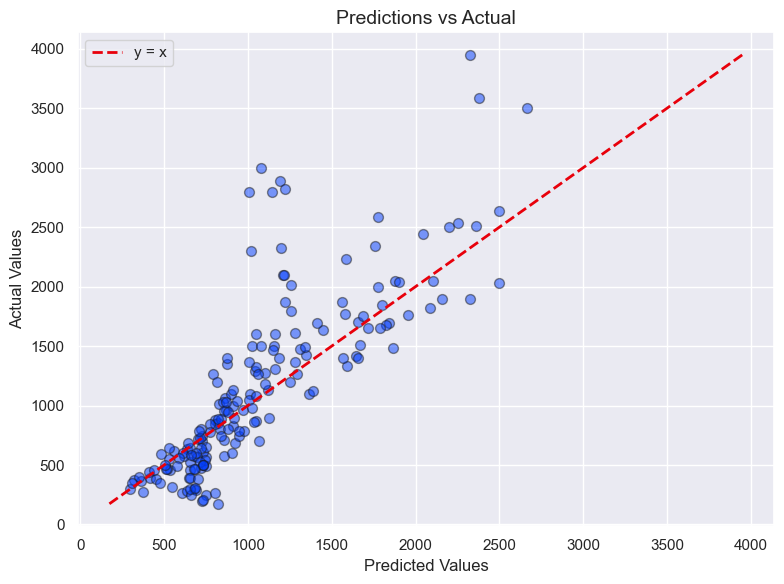

In [42]:
# LGBMRegressor - Results
with open('./models/lgb_grid_laptop_03.pkl', 'rb') as file:
    lgb_grid = pickle.load(file)
    
print(f'Mejores parámetros: {lgb_grid.best_params_}')
print(f'Mejor RMSE: {-lgb_grid.best_score_}')

# Predecir en el conjunto de test
y_pred = lgb_grid.best_estimator_.predict(X_test_tar_enc_std)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")

ml.plot_predictions_vs_actual(np.exp(y_test), np.exp(y_pred))

# 7. Predicción sobre set de Kaggle.

En este apartado cargamos el "test.csv" de Kaggle sobre el que se van a hacer las predicciones para competición. Hay que hacerle todas las transformaciones que se han hecho al conjunto de train. Y de voy a volver a entrenar el modelo con todo el set de train.

In [77]:
# Volver a cargar el set para Train y preparar ambos modelos
train_set = pd.read_csv(r'data/train.csv', index_col=0)
test_set = pd.read_csv(r'data/test.csv', index_col=0)

# Transformar la columna "Weight" a numéricas, y convertir "Inches" en categórica
train_set['RamGB'] = train_set['Ram'].str.replace('GB', '').astype(int)
train_set["WeightKg"] = train_set['Weight'].str.replace('kg', '').astype(float)
train_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

test_set['RamGB'] = test_set['Ram'].str.replace('GB', '').astype(int)
test_set["WeightKg"] = test_set['Weight'].str.replace('kg', '').astype(float)
test_set.drop(['Ram', 'Weight'], axis=1, inplace=True)

# Filtro train_set eliminando lo valores de los outliers del Train
upper_limit = 3500 
train_set = train_set[~(train_set['Price_in_euros'] >= upper_limit)]
train_set.describe()

# Transformación logarítmica del target
train_set['log_price_euros'] = np.log(train_set['Price_in_euros'])
train_set.drop(['Price_in_euros'], axis=1, inplace=True)

# Definir variables numéricas, categóricas y categóricas con alta cardinalidad
target = 'log_price_euros'
num_features = ['WeightKg']
cat_features_high_card = ['Product', 'Cpu', 'Gpu']
cat_features = [col for col in train_set.columns.to_list() if col not in (num_features + [target])]

X_train = train_set.drop(columns=[target])
y_train = train_set[target]

X_test = test_set.copy()

# Redefinir catagorías de alta cardinalidad
cat_features_high_card = ['Product', 'Cpu', 'Gpu', 'ScreenResolution', 'Memory']
cat_features_low_card = [col for col in cat_features if col not in cat_features_high_card]

# Target Encoding
X_train_target_encoded = X_train.copy()
X_test_target_encoded = X_test.copy()

for feature in cat_features_high_card:
    target_mean = pd.concat([X_train, y_train], axis=1).groupby(feature)[target].mean()
    X_train_target_encoded[feature] = X_train_target_encoded[feature].map(target_mean)
    X_test_target_encoded[feature] = X_test_target_encoded[feature].map(target_mean)



# Ordinal Encoding sobre las categóricas representadas con "object"
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
X_train_target_encoded[['Company', 'TypeName', 'OpSys']] = ord_encoder.fit_transform(X_train_target_encoded[['Company', 'TypeName', 'OpSys']])
X_test_target_encoded[['Company', 'TypeName', 'OpSys']] = ord_encoder.transform(X_test_target_encoded[['Company', 'TypeName', 'OpSys']])

# Standard Scaler
std_scaler = StandardScaler()
X_train_tar_enc_std = pd.DataFrame(std_scaler.fit_transform(X_train_target_encoded), 
                                   columns=X_train_target_encoded.columns,
                                   index=X_train_target_encoded.index)
X_test_tar_enc_std = pd.DataFrame(std_scaler.transform(X_test_target_encoded), 
                                  columns=X_test_target_encoded.columns,
                                  index=X_test_target_encoded.index)

# display(X_train_tar_enc_std.head())
# display(X_test_tar_enc_std.head())
# display(X_test)


### Random Forest prediction

In [83]:
model = 'forest_grid_laptop_03.pkl'
subm = 'submission_forest_best_model_03.csv'
with open(f'./models/{model}', 'rb') as file:
    model = pickle.load(file)

# Mejor modelo 
best_model = model.best_estimator_

# Entrenar modelo
best_model.fit(X_train_tar_enc_std, y_train)

# Predicción
pred = np.exp(best_model.predict(X_test_tar_enc_std))

submission = pd.DataFrame({'laptop_ID': X_test_tar_enc_std.index, 
                           'Price_in_euros': pred})
display(submission.head())

kaggle_checker(submission, 
               path=f'./submissions/{subm}'
               )

,laptop_ID,Price_in_euros
0,209,1187.889857
1,1281,288.446090
2,1168,742.708202
3,1231,1134.502829
4,1020,1004.987488


You're ready to submit!


### LightGBM Regressor

In [84]:
model = 'lgb_grid_laptop_03.pkl'
subm = 'submission_lgb_best_model_03.csv'
with open(f'./models/{model}', 'rb') as file:
    model = pickle.load(file)

# Mejor modelo 
best_model = model.best_estimator_

# Entrenar modelo
best_model.fit(X_train_tar_enc_std, y_train)

# Predicción
pred = np.exp(best_model.predict(X_test_tar_enc_std))

submission = pd.DataFrame({'laptop_ID': X_test_tar_enc_std.index, 
                           'Price_in_euros': pred})
display(submission.head())

kaggle_checker(submission, 
               path=f'./submissions/{subm}'
               )

,laptop_ID,Price_in_euros
0,209,1304.516966
1,1281,267.887863
2,1168,535.376384
3,1231,889.873670
4,1020,1062.152167


You're ready to submit!
